<a href="https://colab.research.google.com/github/Yacin-e/coin-detection/blob/main/ProjetAnalyseImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Projet image

import math
import numpy as np
import cv2
import matplotlib.pyplot as plt


# affichage / conversion

def show(img, title="", cmap=None, figsize=(7, 7)):
    plt.figure(figsize=figsize)
    if img is None:
        plt.title(title + " (None)"); plt.axis("off"); plt.show(); return
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis("off"); plt.show()


def euros_str(total):
    euros = int(total)
    cents = int(round((total - euros) * 100))
    if cents == 100:
        euros += 1; cents = 0
    return f"{euros}€ et {cents:02d} centimes"

# Diamètres réels des pièces euro (mm)

EURO_DIAM_MM = {
    2.00: 25.75,
    1.00: 23.25,
    0.50: 24.25,
    0.20: 22.25,
    0.10: 19.75,
    0.05: 21.25,
    0.02: 18.75,
    0.01: 16.25,
}

# Ratio par rapport au diamètre de la pièce de 2€ (référence max)
REF_DIAM = EURO_DIAM_MM[2.00]
EURO_RATIO = {val: EURO_DIAM_MM[val] / REF_DIAM for val in EURO_DIAM_MM}

FAMILY_VALUES = {
    "bimetal": [1.00, 2.00],
    "gold":    [0.10, 0.20, 0.50],
    "copper":  [0.01, 0.02, 0.05],
}


# Caractéristiques couleur HSV (anneau vs centre)

def ring_center_features_hsv(bgr, cx, cy, r):

    h, w = bgr.shape[:2]
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

    cx_i, cy_i = int(round(cx)), int(round(cy))
    r_center = max(2, int(round(0.45 * r)))
    r_in     = max(2, int(round(0.70 * r)))
    r_out    = max(2, int(round(0.95 * r)))

    mask_c = np.zeros((h, w), dtype=np.uint8)
    mask_r = np.zeros((h, w), dtype=np.uint8)

    cv2.circle(mask_c, (cx_i, cy_i), r_center, 255, -1)
    cv2.circle(mask_r, (cx_i, cy_i), r_out,    255, -1)
    cv2.circle(mask_r, (cx_i, cy_i), r_in,     0,   -1)

    Hc, Sc, Vc, _ = cv2.mean(hsv, mask=mask_c)
    Hr, Sr, Vr, _ = cv2.mean(hsv, mask=mask_r)

    dH = abs(float(Hc) - float(Hr))
    dS = abs(float(Sc) - float(Sr))
    return float(Hc), float(Sc), float(Vc), float(Hr), float(Sr), float(Vr), dH, dS


def classify_family(Hc, Sc, Hr, Sr, dH, dS,
                    bimetal_dH=12.0, bimetal_dS=35.0, copper_H_max=18.0):

    if dH >= bimetal_dH or dS >= bimetal_dS:
        return "bimetal"
    if Hc <= copper_H_max:
        return "copper"
    return "gold"

# Classification par rayon normalisé

def classify_value(family, r, r_max):
    if r_max < 1e-6:
        return None
    rn = r / r_max
    candidates = FAMILY_VALUES[family]
    best_val, best_err = candidates[0], 1e9
    for val in candidates:
        err = abs(rn - EURO_RATIO[val])
        if err < best_err:
            best_err = err
            best_val = val
    return float(best_val)

# Pipeline — Hough Circles─

def detect_coins(
    bgr,
    max_size=900,
    # --- Hough params (à ajuster selon ta résolution / tes pièces) ---
    dp=1.2,           # résolution inverse de l'accumulateur (1 = même résolution que l'image)
    min_dist_ratio=0.12,  # distance min entre centres en fraction de la largeur
    param1=80,        # seuil haut pour Canny interne à HoughCircles
    param2=50,        # seuil accumulateur (bas = plus de faux positifs)
    min_r_ratio=0.03, # rayon min en fraction de la largeur
    max_r_ratio=0.22, # rayon max en fraction de la largeur
    debug=True
):

    # 1. Redimensionner
    h0, w0 = bgr.shape[:2]
    scale = max_size / max(h0, w0)
    if scale < 1.0:
        bgr = cv2.resize(bgr, (int(w0*scale), int(h0*scale)),
                         interpolation=cv2.INTER_AREA)
    h, w = bgr.shape[:2]

    # 2. Prétraitement
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Amélioration du contraste (CLAHE) → aide beaucoup sur fond non uniforme
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray)

    # Flou median : réduit le bruit tout en préservant les contours circulaires
    blurred = cv2.medianBlur(gray_eq, 7)

    # 3. Détection Hough Circles
    min_dist = int(w * min_dist_ratio)
    min_r    = int(w * min_r_ratio)
    max_r    = int(w * max_r_ratio)

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=dp,
        minDist=min_dist,
        param1=param1,
        param2=param2,
        minRadius=min_r,
        maxRadius=max_r
    )

    if circles is None:
        print("⚠️  Aucun cercle détecté. Essaye de baisser param2 ou d'ajuster les ratios.")
        return None

    circles = np.round(circles[0]).astype(int)  # shape (N, 3) : cx, cy, r

    # 4. r_max pour la normalisation
    r_max = float(circles[:, 2].max())

    # 5. Classification de chaque pièce
    coins = []
    for (cx, cy, r) in circles:
        Hc, Sc, Vc, Hr, Sr, Vr, dH, dS = ring_center_features_hsv(bgr, cx, cy, r)
        fam = classify_family(Hc, Sc, Hr, Sr, dH, dS)
        val = classify_value(fam, r, r_max)
        coins.append({
            "cx": cx, "cy": cy, "r": r,
            "family": fam, "value": val,
            "Hc": Hc, "Sc": Sc, "Hr": Hr, "Sr": Sr,
            "dH": dH, "dS": dS
        })

    total = sum(c["value"] for c in coins if c["value"] is not None)

    # 6. Visualisation
    overlay = bgr.copy()
    colors = {"bimetal": (0, 200, 255), "gold": (0, 180, 50), "copper": (50, 80, 210)}
    for c in coins:
        col = colors.get(c["family"], (200, 200, 200))
        cv2.circle(overlay, (c["cx"], c["cy"]), c["r"],     col, 2)
        cv2.circle(overlay, (c["cx"], c["cy"]), 3,          col, -1)
        label = f"{c['value']:.2f}€" if c["value"] is not None else "?"
        cv2.putText(overlay, label,
                    (c["cx"] - 20, c["cy"] + 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, col, 2, cv2.LINE_AA)

    if debug:
        show(bgr,     "Image d'entrée")
        show(gray_eq, "Gray + CLAHE",  cmap="gray")
        show(blurred, "Flou median",   cmap="gray")

        # Visualisation des bords Canny (pour régler param1)
        edges = cv2.Canny(blurred, param1 // 2, param1)
        show(edges, f"Canny (param1={param1})", cmap="gray")

        show(overlay, f"Résultat : {len(coins)} pièce(s) — {euros_str(total)}")

        print("\n──── Détail des pièces détectées ────")
        for i, c in enumerate(coins):
            print(
                f"[{i}] centre=({c['cx']},{c['cy']}) r={c['r']}px "
                f"famille={c['family']:7s} dH={c['dH']:.1f} dS={c['dS']:.1f} "
                f"→ {c['value']:.2f}€"
            )
        print(f"\nTotal détecté : {len(coins)} pièce(s)")
        print(f"Montant total : {euros_str(total)}")

    return {
        "bgr": bgr,
        "gray": gray_eq,
        "blurred": blurred,
        "circles_raw": circles,
        "coins": coins,
        "count": len(coins),
        "total": total,
        "overlay": overlay,
    }




In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/1.jpg              
  inflating: data/10.jpg             
  inflating: data/11.jpg             
  inflating: data/12.jpg             
  inflating: data/13.jpg             
  inflating: data/14.jpg             
  inflating: data/2.jpg              
  inflating: data/3.jpg              
  inflating: data/4.jpg              
  inflating: data/5.jpg              
  inflating: data/6.jpg              
  inflating: data/7.jpg              
  inflating: data/8.jpg              
  inflating: data/9.jpg              
  inflating: data/gt.csv             


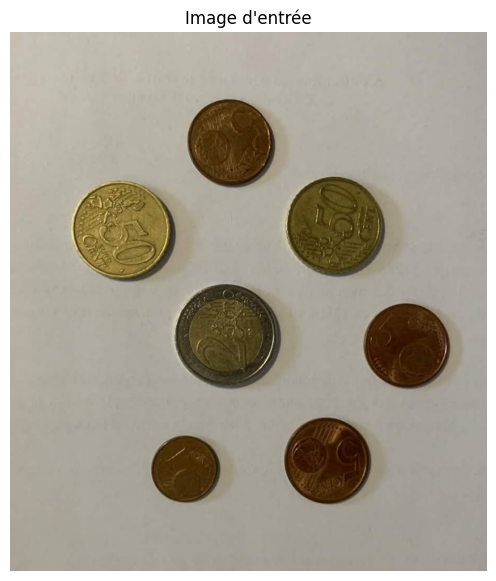

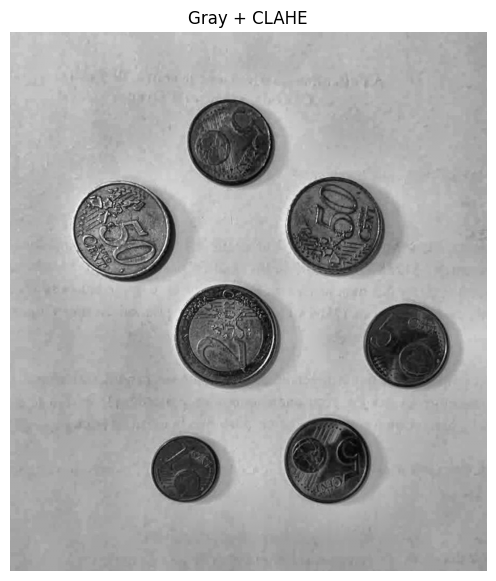

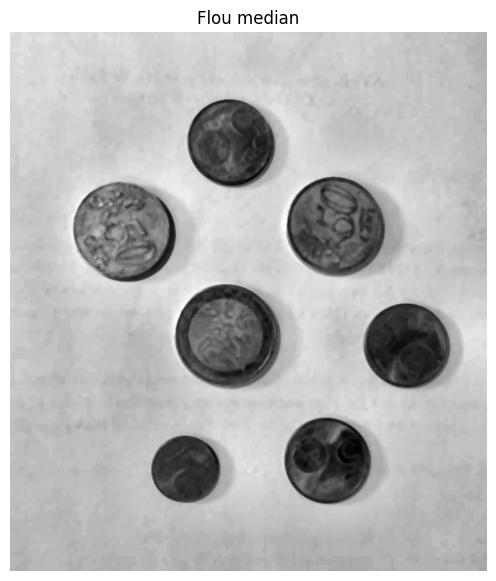

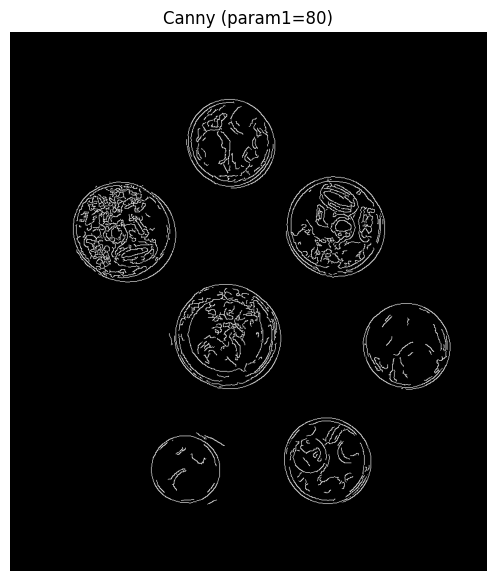

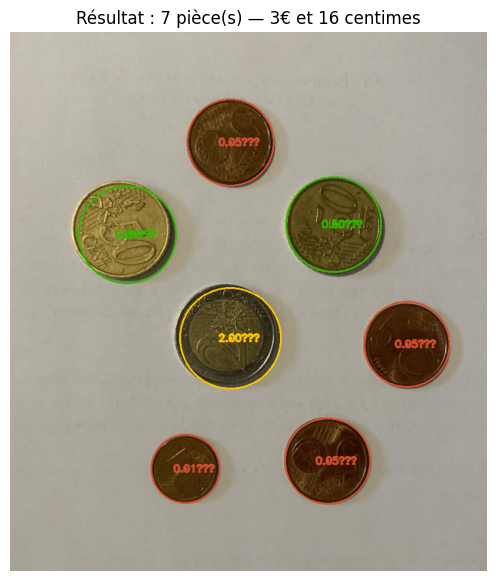


──── Détail des pièces détectées ────
[0] centre=(367,511) r=84px famille=bimetal dH=0.4 dS=40.3 → 2.00€
[1] centre=(195,338) r=81px famille=gold    dH=0.5 dS=8.2 → 0.50€
[2] centre=(367,184) r=72px famille=copper  dH=0.2 dS=7.9 → 0.05€
[3] centre=(539,321) r=79px famille=gold    dH=0.2 dS=3.1 → 0.50€
[4] centre=(529,716) r=71px famille=copper  dH=1.9 dS=14.3 → 0.05€
[5] centre=(661,521) r=71px famille=copper  dH=0.9 dS=22.5 → 0.05€
[6] centre=(292,729) r=57px famille=copper  dH=0.2 dS=13.5 → 0.01€

Total détecté : 7 pièce(s)
Montant total : 3€ et 16 centimes


In [6]:
import cv2

img_path = "data/10.jpg"
bgr = cv2.imread(img_path)

result = detect_coins(
    bgr,
    max_size=900,
    dp=1.2,
    min_dist_ratio=0.12,
    param1=80,
    param2=80,
    min_r_ratio=0.03,
    max_r_ratio=0.22,
    debug=True
)

In [8]:
import os
import pandas as pd

# ────────────────────────────────────────────────────────
IMAGE_FOLDER = "/content/data"   # chemin vers dataset
CSV_PATH     = "/content/data/gt.csv"
PARAMS = dict(max_size=900, dp=1.2, min_dist_ratio=0.15,
              param1=80, param2=70, min_r_ratio=0.04, max_r_ratio=0.22)
# ────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)
results = []

for _, row in df.iterrows():
    filename = row["filename"]
    gt_count = int(row["count"])
    gt_total = float(row["total"])

    path = os.path.join(IMAGE_FOLDER, filename)
    bgr  = cv2.imread(path)
    if bgr is None:
        print(f"⚠️  Image introuvable : {path}")
        continue

    res = detect_coins(bgr, debug=False, **PARAMS)
    pred_count = res["count"]
    pred_total = round(res["total"], 2)

    ok_count = pred_count == gt_count
    ok_total = abs(pred_total - gt_total) < 0.01

    results.append({
        "filename":   filename,
        "gt_count":   gt_count,   "pred_count": pred_count,  "count_ok": ok_count,
        "gt_total":   gt_total,   "pred_total": pred_total,  "total_ok": ok_total,
    })

    status = "✅" if (ok_count and ok_total) else "❌"
    print(f"{status} {filename:10s} | count {gt_count}→{pred_count} | total {gt_total}→{pred_total}€")

# ── Résumé global ────────────────────────────────────────
df_res = pd.DataFrame(results)
n = len(df_res)
acc_count = df_res["count_ok"].sum() / n * 100
acc_total = df_res["total_ok"].sum() / n * 100
print(f"\n{'─'*45}")
print(f"Images testées      : {n}")
print(f"Count correct       : {df_res['count_ok'].sum()}/{n}  ({acc_count:.1f}%)")
print(f"Total correct       : {df_res['total_ok'].sum()}/{n}  ({acc_total:.1f}%)")
print(f"Mean count error    : {(df_res['pred_count'] - df_res['gt_count']).abs().mean():.2f}")
print(f"Mean total error    : {(df_res['pred_total'] - df_res['gt_total']).abs().mean():.2f}€")

✅ 1.jpg      | count 8→8 | total 5.38→5.38€
❌ 2.jpg      | count 11→11 | total 8.11→5.53€
❌ 3.jpg      | count 7→7 | total 7.65→5.2€
❌ 4.jpg      | count 8→8 | total 3.51→2.01€
✅ 5.jpg      | count 7→7 | total 3.16→3.16€
❌ 6.jpg      | count 8→8 | total 5.38→4.37€
❌ 7.jpg      | count 7→7 | total 7.65→5.2€
✅ 8.jpg      | count 6→6 | total 2.86→2.86€
✅ 9.jpg      | count 8→8 | total 3.51→3.51€
✅ 10.jpg     | count 7→7 | total 3.16→3.16€
✅ 11.jpg     | count 8→8 | total 2.59→2.59€
❌ 12.jpg     | count 7→7 | total 4.3→3.5€
✅ 13.jpg     | count 2→2 | total 3.0→3.0€
✅ 14.jpg     | count 4→4 | total 7.0→7.0€

─────────────────────────────────────────────
Images testées      : 14
Count correct       : 14/14  (100.0%)
Total correct       : 8/14  (57.1%)
Mean count error    : 0.00
Mean total error    : 0.77€


In [24]:
!rm /content/data/gt.csv